In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

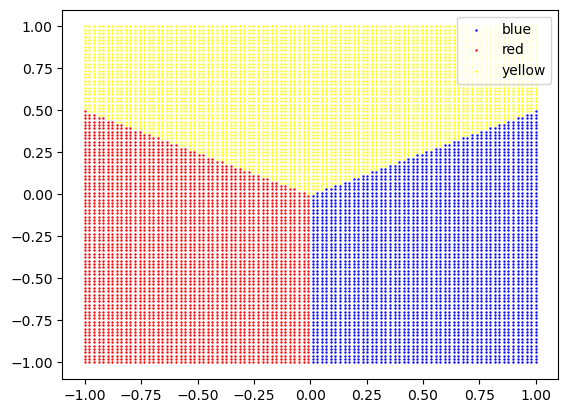

In [2]:
x1 = np.linspace(-1, 1, 100).reshape(-1, 1)
x2 = np.linspace(-1, 1, 100).reshape(-1, 1)
xx1, xx2 = np.meshgrid(x1, x2)
X = np.hstack([xx1.flatten().reshape(-1, 1), xx2.flatten().reshape(-1, 1)])

def asignar_color(X):
    x, y = X[0], X[1]
    if x > 0:
        if y > x * 0.5:
            return np.array('yellow', dtype = '<U8')
        else:
            return np.array('blue', dtype = '<U8')
    if x <= 0:
        if y > x * -0.5:
            return np.array('yellow', dtype = '<U8')
        else:
            return np.array('red', dtype = '<U8')

Y = np.apply_along_axis(asignar_color, 1, X)

df = pd.DataFrame(dict(x=X[:, 0], y=X[:, 1], label=Y))
groups = df.groupby('label')

fig, ax = plt.subplots()
ax.margins(0.05) 
for name, group in groups:
    ax.scatter(group.x, group.y, marker='o', label=name, s = 0.5, c = name)
ax.legend()

plt.show()

encoder = OneHotEncoder()
Y_encoded = encoder.fit_transform(Y.reshape(-1, 1)).toarray()

In [3]:
def initialize_network(input_size, hidden_sizes, output_size):
    """
    Initialize weights and biases for a neural network.
    Args:
        input_size: Number of inputs to the network.
        hidden_sizes: List of neurons in each hidden layer (n, m, l...) size of layer n, size of layer m
        etc.
        output_size: Number of outputs of the network.
    Returns:
    List of (weights, biases) tuples for each layer.
    """
    layer_sizes = [input_size] + hidden_sizes + [output_size]
    #print('Layer sizes:',layer_sizes)
    network = []
    for i in range(len(layer_sizes) - 1):
        weights = np.random.randn(layer_sizes[i + 1], layer_sizes[i]) * 0.1
        # This creates a 2D array of random values with shape (layer_sizes[i + 1], layer_sizes[i]),
        # where each entry represents the weight connecting a neuron in the current layer to a
        # neuron in the next layer.
        biases = np.zeros(layer_sizes[i + 1])
        network.append((weights, biases))
    return network

# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return (x > 0) * x

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def relu_derivative(x):
    return (x > 0) * 1

def forward_layer_batch(inputs, weights, biases):
    """
    Perform a forward pass for a layer with a batch of inputs.
    Args:
    inputs: Input to the layer (2D array: batch_size x input_features).
    weights: Weights of the layer (2D array: neurons x input_features).
    biases: Biases of the layer (1D array: neurons).
    Returns:
    Outputs of the layer (2D array: batch_size x neurons).
    """
    z = np.dot(inputs, weights.T) + biases # Weighted sum (broadcast biases)
    return sigmoid(z), z
    #return relu(z), z

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
def forward_network_batch_softmax(inputs, network):
    """
    Perform a forward pass through the network for a batch of inputs.
    Args:
    inputs: Input to the network (2D array: batch_size x input_features).
    network: List of (weights, biases) for each layer.
    Returns:
    Activations for all layers.
    """
    activations = [inputs]
    preactivations = [inputs]
    for i, (weights, biases) in enumerate(network):
        inputs, preactivation = forward_layer_batch(inputs, weights, biases)
        activations.append(inputs)
        preactivations.append(preactivation)
        # Apply softmax for the output layer (last layer)
        if i == len(network)-1:
            preactivations.append(inputs)
            inputs = softmax(inputs)
            activations.append(inputs)
    return activations, preactivations

# Binary Cross-Entropy (BCE) loss function
def bce_loss(y_pred, y_true):
    return -np.mean(y_true * np.log(y_pred + 1e-15) + (1 - y_true) * np.log(1 - y_pred + 1e-15))
    # Gradient of BCE loss w.r.t. predictions

def bce_loss_derivative(y_pred, y_true):
    return -(y_true / (y_pred + 1e-15)) + ((1 - y_true) / (1 - y_pred + 1e-15))

In [4]:
def backward_layer_batch(inputs, weights, d_loss, activation_derivative):
    """
    Perform a backward pass for a layer with a batch of inputs.
    Args:
    inputs: Input to the layer (2D array: batch_size x input_features).
    weights: Weights of the layer (2D array: neurons x input_features).
    biases: Biases of the layer (1D array: neurons).
    d_loss: Gradients of the loss w.r.t. layer outputs (2D array: batch_size x neurons).
    activation_derivative: Derivative of the activation function (2D array: batch_size x neurons).
    Returns:
    d_weights: Gradients of the weights (2D array: neurons x input_features).
    d_biases: Gradients of the biases (1D array: neurons).
    d_inputs: Gradients of the inputs to propagate backward (2D array: batch_size x
    input_features).
    """

    # Gradients w.r.t. activations
    d_activation = d_loss * activation_derivative

    # Gradients w.r.t. weights and biases (average across batch)
    d_weights = np.dot(d_activation.T, inputs) / len(inputs) # (neurons x inputs)
    d_biases = np.mean(d_activation, axis=0) # Average across batch

    # Gradients to propagate backward to the previous layer
    d_inputs = np.dot(d_activation, weights) # (batch_size x input_features)

    return d_weights, d_biases, d_inputs


def backward_network_batch_softmax(activations_res, network, y_true, learning_rate):
    """
    Perform a backward pass through the network for a batch of inputs using softmax and BCE
    loss.
    Args:
    activations: Activations from the forward pass.
    network: List of (weights, biases) for each layer.
    y_true: True output values (2D array: batch_size x output_neurons).
    learning_rate: Learning rate for updates.
    Returns:
    Loss for the batch.
    """
    activations = activations_res[0]
    preactivations = activations_res[1]
    
    y_pred = activations[-1] # Final layer activations (softmax outputs)
    loss = bce_loss(y_pred, y_true) # Compute BCE loss for the batch
    d_loss = bce_loss_derivative(y_pred, y_true) # Gradient of BCE loss w.r.t. Predictions
    # Backward pass through each layer
    for i in reversed(range(len(network))):
        weights, biases = network[i]
        inputs = activations[i]
    # Compute activation derivative:
    # If it's the output layer, we already have d_loss from BCE, no sigmoid derivative is needed
        if i == len(network) - 1:
            activation_derivative = 1 # Softmax with BCE has a direct gradient
        else:
            activation_derivative = sigmoid_derivative(preactivations[i + 1])
        # Compute gradients
        d_weights, d_biases, d_loss = backward_layer_batch(inputs, weights, d_loss,
        activation_derivative)
        # Update weights and biases
        network[i] = (
        weights - learning_rate * d_weights,
        biases - learning_rate * d_biases
        )
    return loss

def train_network(hidden_layers, epochs, lr, X, Y,
                  decrease_lr = False, verbose = False, 
                  rate_scheduler = 0.99, epochs_scheduler = 1000):

    nw = initialize_network(2, hidden_layers, 3)
    losses = []
    lrs = []
    
    for n in range(epochs):
        lrs.append(lr)
        activation = forward_network_batch_softmax(X, nw)
        losses.append(backward_network_batch_softmax(activation, nw, Y, lr))
    
        if decrease_lr:
            if (n % epochs_scheduler == 0):
                lr = lr * rate_scheduler

        if (n % 1000 == 0) and verbose:
            print('Epoch: ', n, '; Loss: ', losses[-1])
            
    activation = forward_network_batch_softmax(X, nw)
    ypred = activation[0][-1]

    return losses, ypred, lrs

In [5]:
nw = initialize_network(2, [3, 3], 3)
activations_res = forward_network_batch_softmax(X, nw)
backward_network_batch_softmax(activations_res, nw, Y_encoded, 0.01)

np.float64(0.6357985350431117)

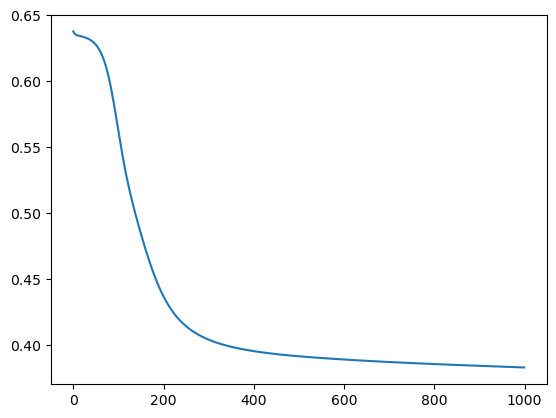

In [51]:
losses, y_pred, _ = train_network([10], 1000, 0.1, X, Y_encoded)
plt.plot(losses)

In [52]:
y_pred.argmax(axis = 1)
label_encoder = LabelEncoder()
Y_encoded_labels = label_encoder.fit_transform(Y)

0.9346
[[2830   96  199]
 [ 123 2816  186]
 [  50    0 3700]]


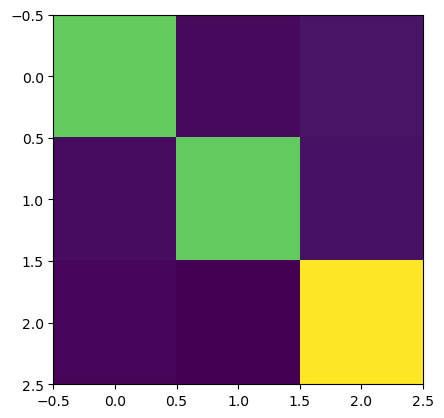

In [53]:
print(accuracy_score(Y_encoded_labels, y_pred.argmax(axis = 1)))
print(confusion_matrix(Y_encoded_labels, y_pred.argmax(axis = 1)))
plt.imshow(confusion_matrix(Y_encoded_labels, y_pred.argmax(axis = 1)), cmap = 'viridis')
plt.show()